In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

In [ ]:
import pickle as pkl
with open('../../misc/predictions/Final_test.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [5]:
PD['m5']['MCMC']['m1']['metric']['GR-ratio']

{'lockdown_R0': 1.006964513054995,
 'T_inc': 1.0036739723513766,
 'T_inf': 1.0271472650733706,
 'T_recov': 1.0345137840428673,
 'T_recov_fatal': 1.034075389607469,
 'P_fatal': 1.0122148911041065,
 'E_hosp_ratio': 1.0235843339985597,
 'I_hosp_ratio': 1.02652882800141,
 'gamma': 1.1049960548265296}

In [6]:
import pandas as pd
PD['m7']['MCMC']['ensemble_mean_forecast']['df_loss']

{'active': 15.724083808275049,
 'recovered': 0.5216816766255198,
 'deceased': 4.969680769607964,
 'total': 1.056189861329191}

In [7]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [81]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [82]:
df_compiled['MCMC'][0]

total         0.46592
active        4.54688
recovered    0.684997
deceased     0.440443
agg           1.53456
Name: train, dtype: object

In [83]:
import pandas as pd
stats = {}
stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]

In [84]:
stats['BO'].loc[['mean']]

,total,active,recovered,deceased,agg
mean,0.373793,3.576508,0.623847,0.324288,1.224609


## Comparing best loss from MCMC vs BO

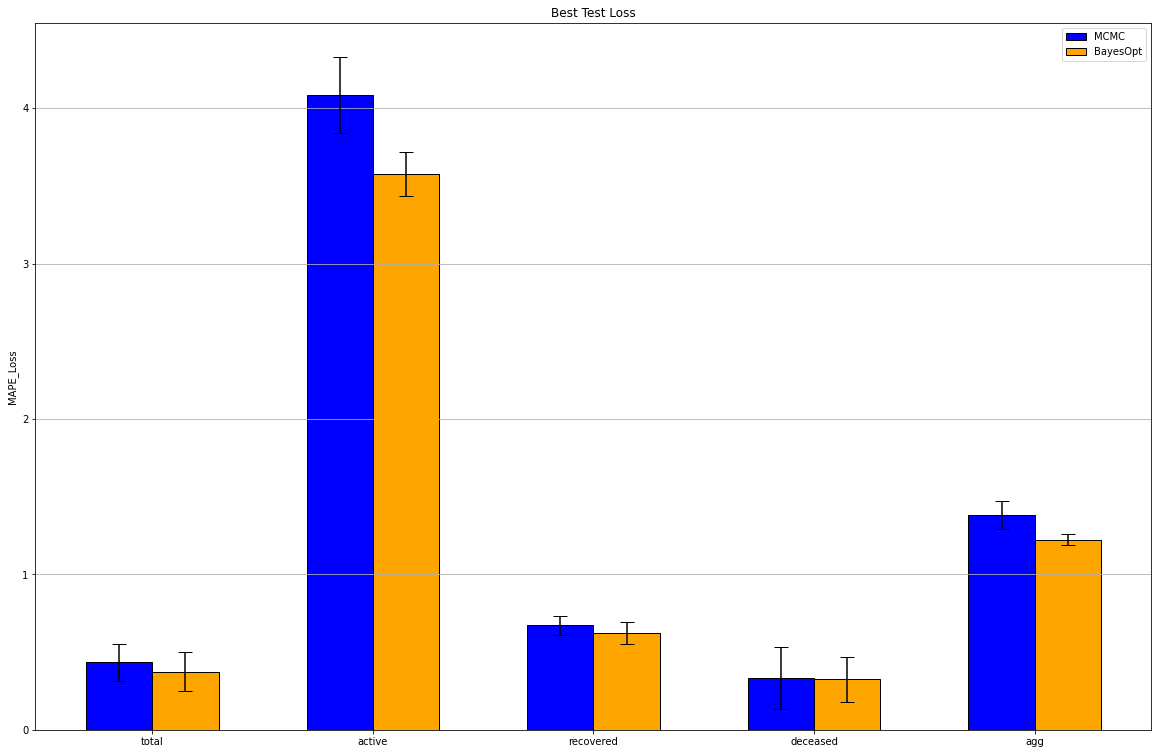

In [85]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.3

plt.figure(figsize=(20,13))
# Choose the height of the blue bars
bars1 = stats['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Best Test Loss')
plt.legend()
 
# Show graphic
plt.show()


## Comparing Ensemble loss from MCMC vs BO

In [72]:
df_compiled_ens = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['ensemble_mean_forecast']['df_loss']
        df['agg'] = np.mean(list(df.values()))
        df2 = {comp:df[comp] for comp in which_compartments}
        df_compiled_ens[model].append(df2)

In [73]:
import pandas as pd
stats_ens = {}
stats_ens['MCMC'] = (pd.DataFrame(df_compiled_ens['MCMC']).describe()).loc[['mean','std']]
stats_ens['BO'] = (pd.DataFrame(df_compiled_ens['BO']).describe()).loc[['mean','std']]

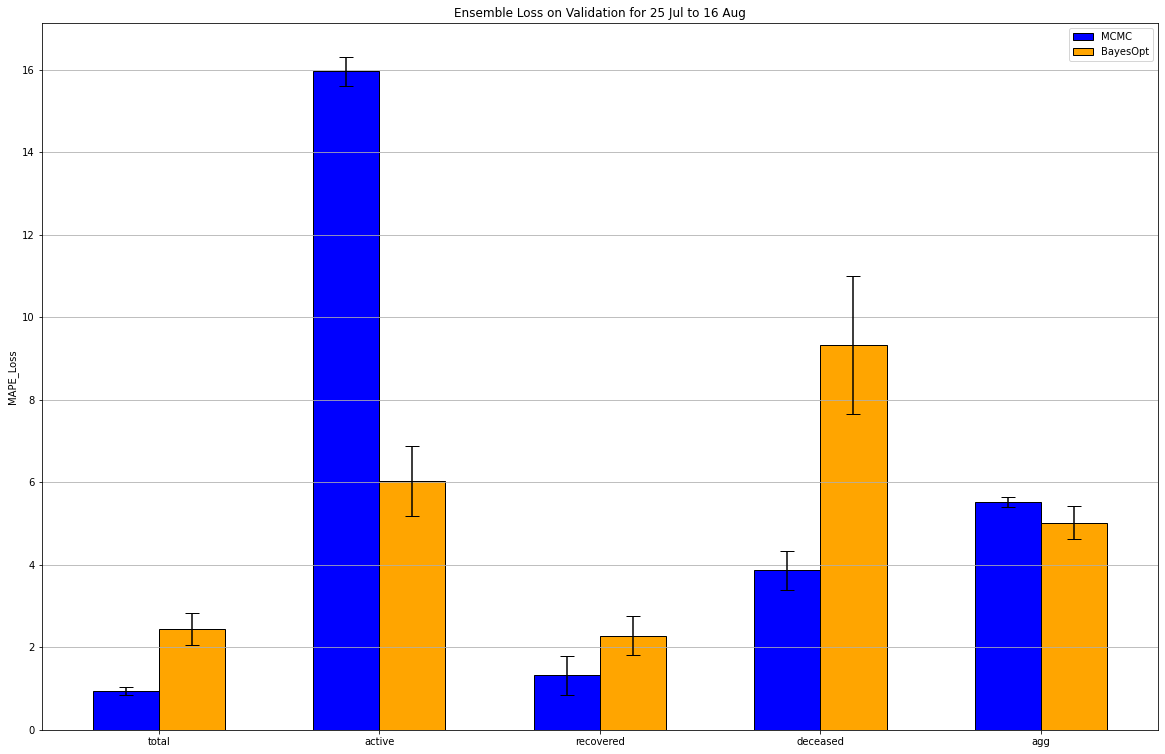

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(20,13))
# Choose the height of the blue bars
bars1 = stats_ens['MCMC'].loc[['mean']].values[0]
 
# Choose the height of the cyan bars
bars2 = stats_ens['BO'].loc[['mean']].values[0]
 
# Choose the height of the error bars (bars1)
yer1 = stats_ens['MCMC'].loc[['std']].values[0]
 
# Choose the height of the error bars (bars2)
yer2 = stats_ens['BO'].loc[['std']].values[0]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], which_compartments)
plt.ylabel('MAPE_Loss')
plt.title('Ensemble Loss on Validation for 25 Jul to 16 Aug')
plt.legend()
 
# Show graphic
plt.show()

## DIC 

In [ ]:
df_compiled_DIC = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['metric']['DIC']
        df_compiled_DIC[model].append(df)
df_compiled_DIC

In [ ]:
barWidth = 0.3
plt.figure(figsize=(10,13))
# Choose the height of the blue bars
bars1 = [np.mean(df_compiled_DIC['MCMC'])]
 
# Choose the height of the cyan bars
bars2 = [np.mean(df_compiled_DIC['BO'])]
 
# Choose the height of the error bars (bars1)
yer1 = [np.std(df_compiled_DIC['MCMC'])]
 
# Choose the height of the error bars (bars2)
yer2 = [np.std(df_compiled_DIC['BO'])]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='MCMC')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', yerr=yer2, capsize=7, label='BayesOpt')
 
# general layout
plt.grid(b = True,axis = 'y')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['MCMC                                    BO'])
plt.ylabel('DIC')
plt.title('DIC Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

## Percentile Loss

In [33]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc'].values[0][2]
        df_compiled_perc_loss[model].append(df)

In [34]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

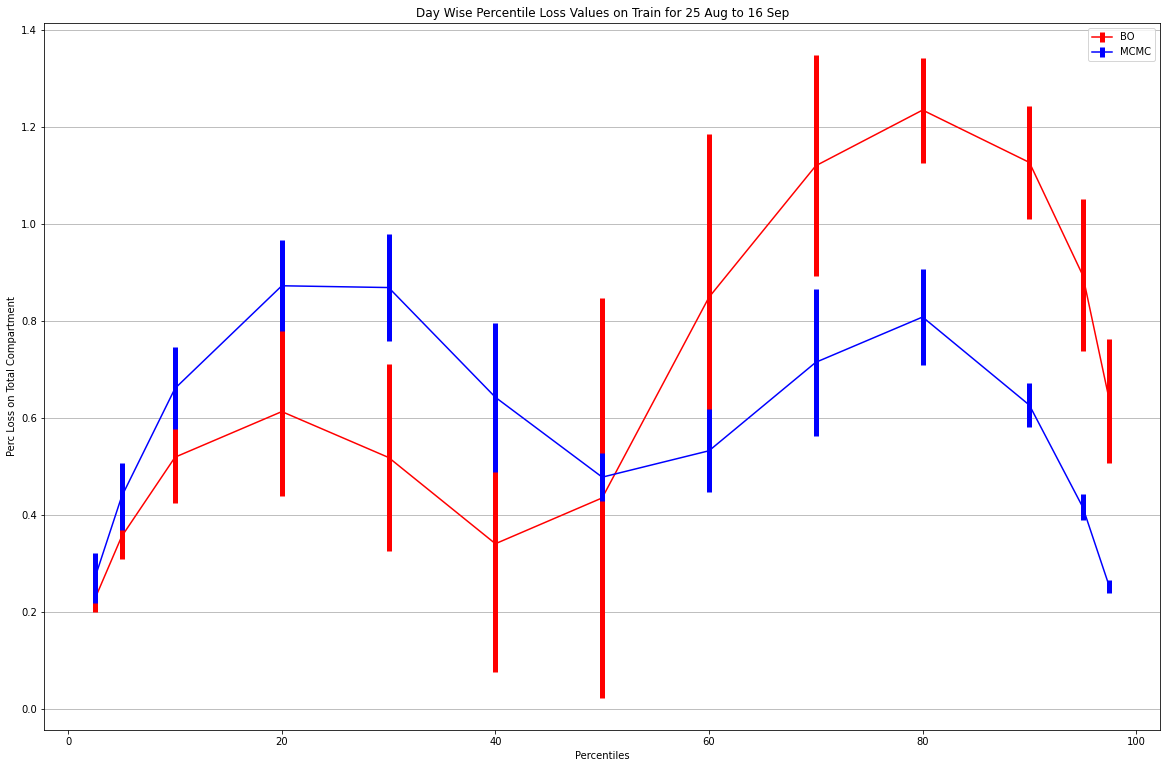

In [36]:
import matplotlib as mpl
barWidth = 0.3

plt.figure(figsize=(20,13))
plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'red',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =5,capthick =3,barsabove = True)
plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =5,capthick =3,barsabove = True)


# general layout
plt.grid(b = True,axis = 'y')
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
plt.title('Day Wise Percentile Loss Values on Train for 25 Aug to 16 Sep')
plt.legend()
 
# Show graphic
plt.show()

In [37]:
from viz.fit import plot_comp_density_plots,plot_histogram

(<Figure size 864x1224 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'Denisty Plot of parameter E_hosp_ratio'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter I_hosp_ratio'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter P_fatal'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_inc'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_inf'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter T_recov'}, ylabel='Density'>],
        [<AxesSubplot:title={'center':'Denisty Plot of parameter T_recov_fatal'}, ylabel='Density'>,
         <AxesSubplot:title={'center':'Denisty Plot of parameter lockdown_R0'}, ylabel='Density'>]],
       dtype=object))

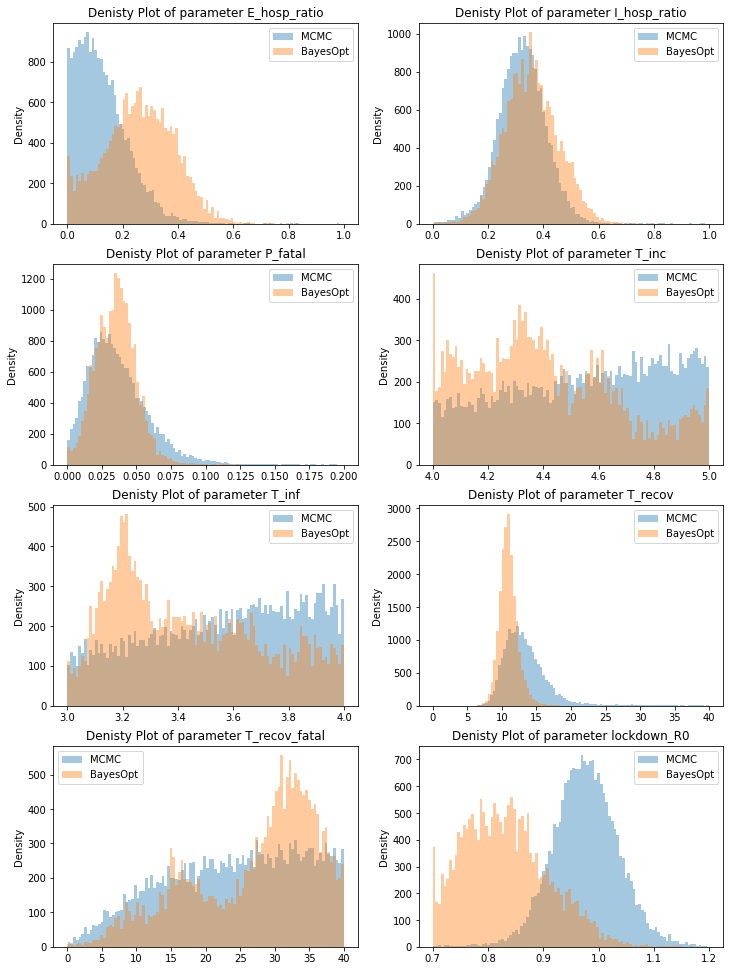

In [38]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
plot_comp_density_plots(PD,figs,axs)